# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, необходимо разобраться, какой тариф приносит больше денег.
У нас есть данные о 500 пользователях «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. На основании этих данных проведем предварительный анализ тарифов на небольшой выборке клиентов. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.


## Изучение данных из файла

Описание данных:


Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана


Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Импортируем нужные библиотеки для работы и прочтем файлы с данными:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import ceil as math

In [53]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
massages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
#users.tail(10)
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [4]:
users.shape

(500, 8)

In [5]:
#calls.tail(10)
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [6]:
calls.shape

(202607, 4)

In [7]:
#internet.tail(10)
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [8]:
internet.shape

(149396, 4)

In [9]:
#massages.tail(10)
massages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [10]:
massages.shape

(123036, 3)

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [13]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [15]:
massages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [17]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [18]:
calls.loc[calls['duration'] == 0]['duration'].count()

39613

Примерно 19.6 % процентов звонков длительностью 0.0 минут. Эти звонки могут быть пропущенными, тоесть являться исходящими звонками, на которые не было ответа. Входящие звонки мы не рассматриваем, так как смысла анализировать входящие нет - они никак не влияют на тариф и являются бесплатными. Разделения на входящие и исходящие в таблице нет, поэтому можно считать, что эти звонки все таки исходящие.

Эти звонки внесены в таблицу, а значит - уже тарифицируются, поэтом в дальнейшем у их можно округлить до единицы.

In [19]:
internet.loc[internet['mb_used']==0]['mb_used'].count()

19598

~13% пользователей не использовали свой трафик. По трафику ситуация аналогична, тарификация по пакетам услуг для этих клиетов уже началась. Можем и эти значения округлить до единцы.

## Предобработка данных

In [20]:
calls['id'] = calls['id'].astype('int64')
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.2 MB


In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()
#users.info()
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaT,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaT,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaT,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaT,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


Заменим типы данных в таблице internet:

In [22]:
internet['id'] = internet['id'].astype(int)
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  int64         
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 5.7 MB


In [23]:
massages['id'] = massages['id'].astype(int)
massages['message_date'] = pd.to_datetime(massages['message_date'])
massages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


In [24]:
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [25]:
calls.loc[calls['duration'] == 0, 'duration'] = 1
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1
print('Количество нулевых значений по длительности звонков равно',calls.loc[calls['duration'] == 0]['duration'].count())
print('Количество нулевых значений по использованию трафика равно',internet.loc[internet['mb_used']==0]['mb_used'].count())

Количество нулевых значений по длительности звонков равно 0
Количество нулевых значений по использованию трафика равно 0


## Расчет данных по тарифам для кажого пользователя

Расчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Создадим общую таблицу, в которой будет отражены данные по количеству звонков, сообщений и израсходованного интернет трафика по месяцам для каждого польователя. Для этого изначально создадим несколько сводных таблиц по кадому из параметров, а после - объединим эти данные в одну общую таблицу.

Создадим сводную таблицу по количеству сделанных звонков и израсходованных минут разговора по месяцам:

In [54]:

# добавим стобец со значением месяца
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
# объединим таблицы calls и users по user_id
merge_calls_users = calls.merge(users, on = 'user_id', how = 'inner')

# теперь создадим сводую таблицу, в которой подсчитаем количество сделанных звонков и израсходованных минут разговора по месяцам
pivot_calls = merge_calls_users.pivot_table(index=['user_id','month'], values = 'duration',
                                aggfunc = {'user_id':'count','duration':'sum'}
                                           ).rename(columns = {'user_id':'calls_amount'})
pivot_calls.head(10)

duration  calls_amount
user_id month                        
1000    5        150.06            22
        6        158.90            43
        7        318.80            47
        8        389.87            52
        9        440.14            58
        10       328.45            57
        11       319.04            43
        12       312.98            46
1001    11       408.12            59
        12       391.34            63

По аналогии создадим таблицу по количеству отправленных сообщений по месяцам:

In [28]:
#код после ревью
massages['month'] = pd.DatetimeIndex(massages['message_date']).month
merge_massages_users = massages.merge(users, on = 'user_id', how = 'inner')

pivot_massages = merge_massages_users.pivot_table(index=['user_id','month'], values ='id',
                                aggfunc = {'id':'count'}
                                           ).rename(columns = {'id':'massages_amount'})
pivot_massages.head(10)

massages_amount
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
        10                  73
        11                  58
        12                  70
1002    6                    4
        7                   11

И также созддадим таблицу с рассчетом объема израсходованного интернет-трафика по месяцам для каждого пользователя:

In [29]:
#код после ревью
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
merge_internet_users = internet.merge(users, on = 'user_id', how = 'inner')

pivot_internet = merge_internet_users.pivot_table(index=['user_id','month'], values ='mb_used',
                                aggfunc = {'mb_used':'sum'}
                                           ).rename(columns = {'mb_used':'mb_amount'})
pivot_internet.head(10)

mb_amount
user_id month           
1000    5         2257.0
        6        23262.0
        7        14017.0
        8        14072.0
        9        14583.0
        10       14717.0
        11       14769.0
        12        9829.0
1001    11       18460.0
        12       14059.0

Теперь создадим общую таблицу, в которой будет отражены данные по количеству звонков, сообщений, израсходованного интернет трафика и выручки по месяцам для каждого польователя, объединив три текущие таблицы:

In [30]:
all_pivot = [pivot_calls, pivot_massages, pivot_internet]
from functools import reduce
traffic_values_for_users = reduce(lambda left,right: pd.merge(left,right,
                            on=['user_id','month'],how='outer'), all_pivot).reset_index()
traffic_values_for_users.head(10)

,user_id,month,duration,calls_amount,massages_amount,mb_amount
0,1000,5,164.0,22.0,22.0,2257.0
1,1000,6,187.0,43.0,60.0,23262.0
2,1000,7,346.0,47.0,75.0,14017.0
3,1000,8,418.0,52.0,81.0,14072.0
4,1000,9,478.0,58.0,57.0,14583.0
5,1000,10,363.0,57.0,73.0,14717.0
6,1000,11,344.0,43.0,58.0,14769.0
7,1000,12,341.0,46.0,70.0,9829.0
8,1001,11,444.0,59.0,NaN,18460.0
9,1001,12,430.0,63.0,NaN,14059.0


In [31]:
traffic_values_for_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3214 non-null   int64  
 1   month            3214 non-null   int64  
 2   duration         3174 non-null   float64
 3   calls_amount     3174 non-null   float64
 4   massages_amount  2717 non-null   float64
 5   mb_amount        3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


In [32]:
traffic_values_for_users = traffic_values_for_users.fillna(0)

traffic_values_for_users['duration'] = traffic_values_for_users['duration'].astype(int)
traffic_values_for_users['calls_amount'] = traffic_values_for_users['calls_amount'].astype(int)
traffic_values_for_users['massages_amount'] = traffic_values_for_users['massages_amount'].astype(int)
traffic_values_for_users['mb_amount'] = traffic_values_for_users['mb_amount'].astype(int)

traffic_values_for_users.head(10)

,user_id,month,duration,calls_amount,massages_amount,mb_amount
0,1000,5,164,22,22,2257
1,1000,6,187,43,60,23262
2,1000,7,346,47,75,14017
3,1000,8,418,52,81,14072
4,1000,9,478,58,57,14583
5,1000,10,363,57,73,14717
6,1000,11,344,43,58,14769
7,1000,12,341,46,70,9829
8,1001,11,444,59,0,18460
9,1001,12,430,63,0,14059


In [33]:
tariff_names = pd.DataFrame()
tariff_names[['user_id','tariff']] = users[['user_id','tariff']]

traffic_values_for_users = traffic_values_for_users.merge(tariff_names, on = 'user_id', how = 'inner')
traffic_values_for_users.head(10)

,user_id,month,duration,calls_amount,massages_amount,mb_amount,tariff
0,1000,5,164,22,22,2257,ultra
1,1000,6,187,43,60,23262,ultra
2,1000,7,346,47,75,14017,ultra
3,1000,8,418,52,81,14072,ultra
4,1000,9,478,58,57,14583,ultra
5,1000,10,363,57,73,14717,ultra
6,1000,11,344,43,58,14769,ultra
7,1000,12,341,46,70,9829,ultra
8,1001,11,444,59,0,18460,smart
9,1001,12,430,63,0,14059,smart


Теперь расчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана, прибавим абонентскую плату, соответствующую тарифному плану). Создадим функцию profit, корая будет считать прибыль для каждого пользователя по каждому из параметров тарифа:


In [34]:
# заведем переменные по стоимости услуг для каждого тарифа и присвоим им значения исходя из описания тарифов
smart_minutes_included = 500
smart_messages_included = 50
smart_mb_included = 15360
smart_monthly_price = 550
smart_price_for_minute = 3
smart_price_for_message = 3
smart_price_for_mb = 0.1953

ultra_minutes_included = 3000
ultra_messages_included = 1000
ultra_mb_included = 30720
ultra_monthly_price = 1950
ultra_price_for_minute = 1
ultra_price_for_message = 1
ultra_price_for_mb = 0.1464


def profit(row):
    duration = row['duration']
    massages_amount = row['massages_amount']
    mb_amount = row['mb_amount']
    tariff = row['tariff']
    profit_minutes = 0
    profit_messages = 0
    profit_mb = 0
     
    if tariff == 'smart':
        if duration > smart_minutes_included:
            profit_minutes = (duration - smart_minutes_included)*smart_price_for_minute
        if massages_amount > smart_messages_included:
            profit_messages = (massages_amount - smart_messages_included)*smart_price_for_message
        if mb_amount > smart_mb_included:
            profit_mb = (mb_amount - smart_mb_included)*smart_price_for_mb    
        return profit_minutes + profit_messages + profit_mb + smart_monthly_price
        
        
    if tariff == 'ultra':
        if duration > ultra_minutes_included:
            profit_minutes = (duration - ultra_minutes_included)*ultra_price_for_minute
        if massages_amount > ultra_messages_included:
            profit_messages = (massages_amount - ultra_messages_included)*ultra_price_for_message
        if mb_amount > ultra_mb_included:
            profit_mb = (mb_amount - ultra_mb_included)*ultra_price_for_mb   
        return profit_minutes + profit_messages + profit_mb + ultra_monthly_price

Создадим новый столбец profit в таблице traffic_values_for_users, применив функцию profit к этому датафрейму:

In [35]:
traffic_values_for_users['profit'] = traffic_values_for_users.apply(profit, axis = 1)
traffic_values_for_users.head(10)

,user_id,month,duration,calls_amount,massages_amount,mb_amount,tariff,profit
0,1000,5,164,22,22,2257,ultra,1950.00
1,1000,6,187,43,60,23262,ultra,1950.00
2,1000,7,346,47,75,14017,ultra,1950.00
3,1000,8,418,52,81,14072,ultra,1950.00
4,1000,9,478,58,57,14583,ultra,1950.00
5,1000,10,363,57,73,14717,ultra,1950.00
6,1000,11,344,43,58,14769,ultra,1950.00
7,1000,12,341,46,70,9829,ultra,1950.00
8,1001,11,444,59,0,18460,smart,1155.43
9,1001,12,430,63,0,14059,smart,550.00


## Анализ данных

Определим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. 

In [36]:
users_required = traffic_values_for_users.pivot_table(index = 'user_id',
                values = ['duration','massages_amount','mb_amount'], aggfunc = 'sum')

users_required = users_required.merge(tariff_names, on = 'user_id', how = 'inner')
users_required.head(10)

,user_id,duration,massages_amount,mb_amount,tariff
0,1000,2641,496,107506,ultra
1,1001,874,0,32519,smart
2,1002,1561,70,116255,smart
3,1003,3914,380,57331,ultra
4,1004,1024,1192,149194,ultra
5,1005,6772,552,99851,smart
6,1006,3595,0,164495,smart
7,1007,4510,225,131876,smart
8,1008,350,56,13243,smart
9,1009,2235,110,177694,smart


Посчитаем среднее количество, медиану, дисперсию и стандартное отклонение:

In [37]:
statistics_for_users = users_required.pivot_table(index = 'tariff',
                        values = ['duration','massages_amount','mb_amount'],
                        aggfunc = {'duration': [np.mean, np.median, np.var, np.std],
                                   'massages_amount': [np.mean, np.median, np.var, np.std],
                                   'mb_amount': [np.mean, np.median, np.var, np.std]})
statistics_for_users

duration                                    massages_amount         \
               mean  median          std           var            mean median   
tariff                                                                          
smart   2734.988571  2365.5  1795.692129  3.224510e+06      212.608571  141.0   
ultra   3599.108108  3262.0  2755.061845  7.590366e+06      328.533784  251.0   

                                       mb_amount                          \
               std            var           mean    median           std   
tariff                                                                     
smart   223.290034   49858.439468  103407.668571   98029.0  60298.434563   
ultra   337.810143  114115.692728  129705.222973  108052.5  87835.848720   

                      
                 var  
tariff                
smart   3.635901e+09  
ultra   7.715136e+09

Теперь визуализируем данные, построим графики и сравним тарифы:

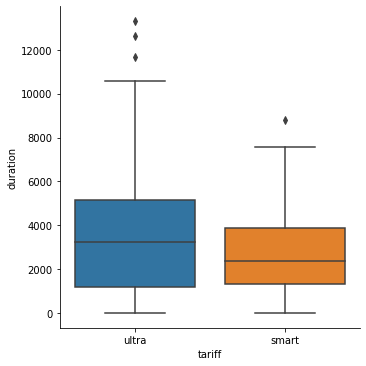

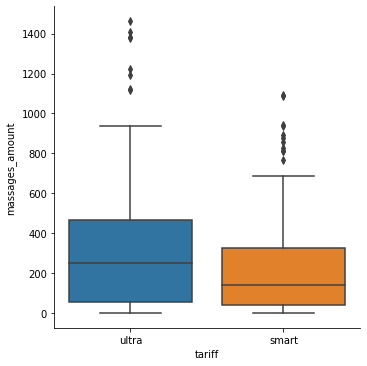

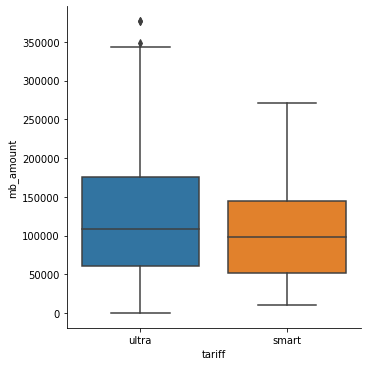

In [38]:
for col in ['duration','massages_amount','mb_amount']:
    sns.catplot(x = 'tariff', y = col, data = users_required, kind = 'box')

Заметны выбросы для каждого из тарифов, причем для тарифа ultra выбросов немного больше, по расходу трафика у тарифа smart выбросов нет совсем. Все три параметра (количество минут, смс и израсходованный трафик) у тарифа ultra имеют более высокие значения по медианам и  дисперсии.

Построим гистрограммы для каждого из тарифов:

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


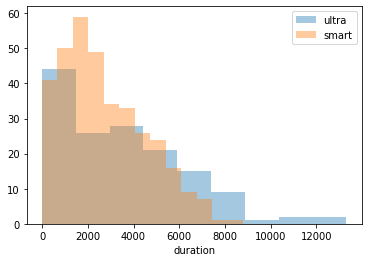

In [39]:
for tariff in ['ultra', 'smart']:
    sns.distplot(users_required.query('tariff == @tariff')['duration'], kde = False)
    plt.legend(labels=['ultra','smart'])

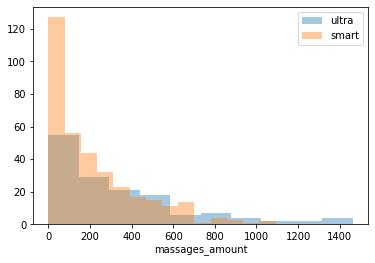

In [40]:
for tariff in ['ultra', 'smart']:
    sns.distplot(users_required.query('tariff == @tariff')['massages_amount'], kde = False)
    plt.legend(labels=['ultra','smart'])

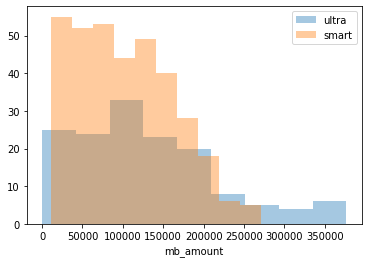

In [41]:
for tariff in ['ultra', 'smart']:
    sns.distplot(users_required.query('tariff == @tariff')['mb_amount'], kde = False)
    plt.legend(labels=['ultra','smart'])

Пользователи тарифа "Ультра" траят большее количество смс, интеренет трафика и проговаривают больше минут, тут все логично. Клиенты тарифа "Смарт" в большей мере используют то, что им предоставлено тарифом (исходя из мод), в то время как клиенты "Ультра" более свободно используют свои минуты, смс и расходуют трафик.

Рассмотрим признаки 'duration','massages_amount','mb_amount' без группировки по пользователям

In [42]:
tariff_ultra = traffic_values_for_users.query('tariff=="ultra"')
tariff_smart = traffic_values_for_users.query('tariff=="smart"')

In [43]:
def hist_for_tariff(column):
    plt.figure(figsize=(10,4))
    sns.distplot(tariff_ultra[column], label='Ultra', kde=False)
    sns.distplot(tariff_smart[column], label='Smart', kde=False)
    plt.legend()

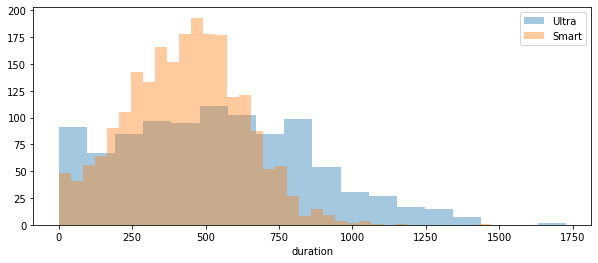

In [44]:
hist_for_tariff('duration')

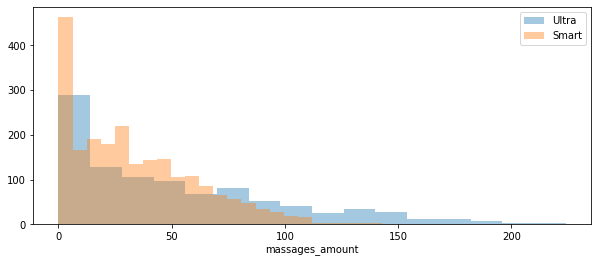

In [45]:
hist_for_tariff('massages_amount')

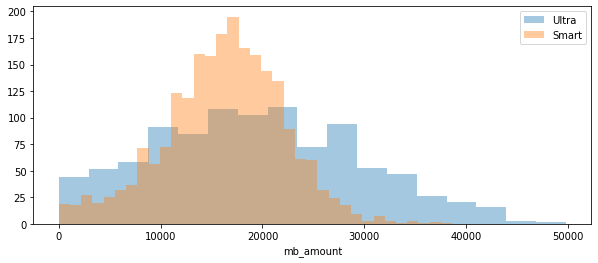

In [46]:
hist_for_tariff('mb_amount')

Исходя из приведенных графиков заметно, что распределение литимов по тарифу "Смарт" не укладывается в рамки трафика ни по одному из параметров. По тарифу "Ультра" ситуация лучше: распределения минут разговра и смс находятся в пределах указанных лимитов по тарифу, по трафику - уже выходит чуть дальше рамок (более 30720 mb)

## Проверка гипотез

$Н_{0}$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы

$Н_{1}$ - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

alpha = 0.05

In [47]:
ultra = traffic_values_for_users.query('tariff=="ultra"')['profit']
smart = traffic_values_for_users.query('tariff=="smart"')['profit']

alpha = 0.05

results = st.ttest_ind(ultra, smart, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:  2.0253297381358686e-281
Отвергаем нулевую гипотезу


Подсчитаем среднюю выручку для каждого тарифа, исходя из наших данных

In [48]:
traffic_values_for_users.pivot_table(index='tariff', values='profit')


,profit
tariff,
smart,1251.374965
ultra,2060.527690


Не смотря на то, что тариф "Ультра" стоит дороже, чем "Смарт", пользователям "Смарт" не всегда хватает имеющегося лимита и им просто приходится переплачивать. Поэтому выручки по этим тарифам существенно отличаются.

Перейдем к следующей гипотезе:

$Н_{0}$ - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

$Н_{1}$ - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

alpha = 0.05

In [49]:
# добавим в датафрейм traffic_values_for_users столбец с городом для каждого пользоваетля
cities = pd.DataFrame()
cities[['user_id','city']] = users[['user_id','city']]

traffic_values_for_users = traffic_values_for_users.merge(cities, on = 'user_id', how = 'inner')
traffic_values_for_users.head()

,user_id,month,duration,calls_amount,massages_amount,mb_amount,tariff,profit,city
0,1000,5,164,22,22,2257,ultra,1950.0,краснодар
1,1000,6,187,43,60,23262,ultra,1950.0,краснодар
2,1000,7,346,47,75,14017,ultra,1950.0,краснодар
3,1000,8,418,52,81,14072,ultra,1950.0,краснодар
4,1000,9,478,58,57,14583,ultra,1950.0,краснодар


In [50]:
moscow = traffic_values_for_users.query('city=="москва"')['profit']
region = traffic_values_for_users.query('city!="москва"')['profit']

alpha = 0.05

results = st.ttest_ind(moscow, region, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5029854971880046
Не получилось отвергнуть нулевую гипотезу


In [51]:
def region(city):
    if city == 'москва':
        return 'москва'
    else:
        return 'другой регион'
    
traffic_values_for_users['region'] = traffic_values_for_users['city'].apply(region)

In [52]:
traffic_values_for_users.pivot_table(index='region', values='profit')

,profit
region,
другой регион,1495.051173
москва,1517.702730


По результатам статистического анализа средняя выручка пользователей из Москвы все таки отличается от выручки пользователей из других регионов, причем средняя выручка в Москве меньше средней выручки в другмх регионах. Возможно жители Москвы предпочитают сразу оплачивать более дорогой тариф и не переплачивают выше лимита, а жители других регионов используют "Смарт", а как мы выяснили ранее - клиенты "Смарта" часто переплачивают из-за недостатка исходного лимита.

## Общий вывод

- Изучили данные 500 клиентов, которые используют тарифы "Смарт" и "Ультра" и произвели предобработку (изменили тип некоторых данных, округлили значения минут и мегабайтов в большую сторону, обработали нулевые значения)
- Для каждого пользователя рассчитали количество звонков, сообщений и израсходованного интернет трафика по месяцам, а также помесячную выручку
- Проанализировав данные о выручках по каждому тарифу и выяснили, что пользователям тарифа «Смарт» не хватает лимита в рамках тарифного пакета, из-за этого клиенты "Смарта" в год приносят больше выручки для компании, чем клиенты "Ультра"
- Произвели статистический анализ и проверили 2 гипотезы:
  - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
  - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
  
  Получили следующее:
  - Не смотря на то, что тариф "Ультра" стоит дороже, чем "Смарт", пользователям "Смарт" не всегда хватает имеющегося лимита и им    просто приходится переплачивать. Поэтому выручки по этим тарифам существенно отличаются, по "Смарту" она больше
  - Средняя выручка пользователей из Москвы меньше выручки пользователей из других регионов. Это, вероятно, связано с тем, что  жители Москвы предпочитают сразу оплачивать более дорогой тариф и не переплачивают выше лимита, а жители других регионов используют "Смарт" и из-за недостатка услуг, входящих в пакет - переплачивают
  
Можем сделать вывод, что с точки зрения прибыли тариф "Смарт" будет лучше, чем тариф "Ультра"